In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import scipy.io as sio
%matplotlib inline

In [23]:
def video_frame_generator(filename):

    # Todo: Open file with VideoCapture and set result to 'video'. Replace None
    video = cv2.VideoCapture(filename)

    # Do not edit this while loop
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame
        else:
            break

    # Todo: Close video (release) and yield a 'None' value. (add 2 lines)
    #raise NotImplementedError
    video.release()
    yield None

In [24]:
VID_DIR='./RGB'
def reading_video(video_name, fps, frame_ids, output_prefix,
                            counter_init):

    video = os.path.join(VID_DIR, video_name)
    image_gen = video_frame_generator(video)

    image = image_gen.next()
    h, w, d = image.shape

    out_path = "output/ar_{}-{}".format(output_prefix[4:], video_name)
    video_out = mp4_video_writer(out_path, (w, h), fps)

    output_counter = counter_init

    frame_num = 1

    while image is not None:

        print("Processing fame {}".format(frame_num))
        plt.imshow(image)
        

        video_out.write(image)

        image = image_gen.next()

        frame_num += 1

    #video_out.release()



In [41]:
#reading_video('a1_s1_t1_color.avi',15,1,'',1)
from mpl_toolkits.mplot3d import Axes3D

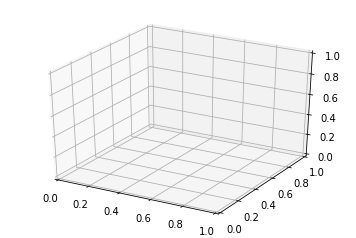

In [29]:
mat_contents = sio.loadmat('Skeleton/a1_s1_t1_skeleton.mat')

In [34]:
d_skel=mat_contents["d_skel"]

In [35]:
len(d_skel)

20

In [50]:
joint = d_skel[:,:,0]
joint[:,0]

array([-0.04576265, -0.03456692, -0.03057881, -0.02558481, -0.19882302,
       -0.23827337, -0.23610309, -0.22907546,  0.13442045,  0.19114332,
        0.2161559 ,  0.21803801, -0.09879873, -0.11512723, -0.07356355,
       -0.10780371,  0.05104091,  0.07187957,  0.0516578 ,  0.09826498])

Text(0.5,0,'Z')

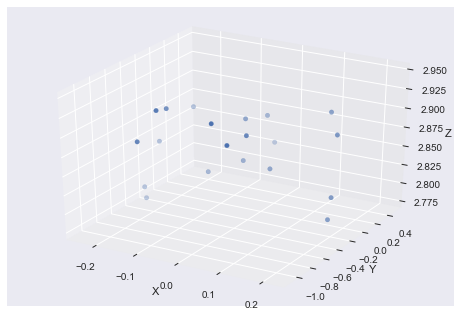

In [102]:
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.pbaspect = [1, 1, 1]
#ax.scatter(joint[:,0],joint[:,1],joint[:,2])
X,Y,Z=joint[:,0],joint[:,1],joint[:,2]

ax.scatter(X,Y,Z)


ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

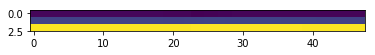

In [40]:
plt.imshow(d_skel[0])